# Final code for R-peak distribution (Date: 2021.08.03)

In [9]:
import os 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

In [57]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]

In [4]:
rpeaks = pd.read_csv(rpeakList[0], header=None)

In [58]:
fxvalList = pd.read_csv(fxvalList[0], header=None)

In [10]:
# min-max normalization 
min_max_scaler = MinMaxScaler()

In [59]:
fxvalList[0]

0        -0.006116
1        -0.006470
2        -0.005763
3        -0.003277
4         0.001115
            ...   
649995    1.071930
649996    0.746051
649997    0.445117
649998    0.182205
649999   -0.053992
Name: 0, Length: 650000, dtype: float64

In [61]:
a = fxvalList[0]

In [65]:
fxvalList

,0
0,-0.006116
1,-0.006470
2,-0.005763
3,-0.003277
4,0.001115
...,...
649995,1.071930
649996,0.746051
649997,0.445117
649998,0.182205


# MinMax Normalized ECG Values 

## R-peak: 100 samples, Euclidean distance 

In [228]:
def rpeak_distribution(rpeakList, fxvalList, ba_set_time, plot_yesno, plot_range, ecl_dist_yesno, ecl_dist_plot_yesno):
    
    # ba_set_time: set before, after time based on rpeak
    # plot_yesno: if you want to make a plot, write "yes" or not "no"
    # ecl_dist_yesno: if you want to calculate euclidean distance, write "yes" or not  "no"
    # ecl_dist_yesno: if you want to plot the distribution of euclidean distance, write "yes" or not "no"
    
    set_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot'

    # min-max normalization 
    min_max_scaler = MinMaxScaler()
    plt.ioff()
   
    for i in range(len(rpeakList)):
            
        # Designate PtId, data type, fxvalId
        PtId = rpeakList[i].split('.csv')[0].split('_')[-1] 
        print('Processing >>>>> ', PtId)
        dtype = rpeakList[i].split('.csv')[0].split('_')[-2]

        fxvalId = rpeakList[i].split('.csv')[0].split('_')[-1]

        # make directgory
        if not os.path.exists(os.path.join(set_path, dtype, 'ba'+str(ba_set_time))):
            os.mkdir(os.path.join(set_path, dtype, 'ba'+str(ba_set_time)))
        else:
            pass

        
        # Check id, if they are same, load each file
        if PtId == fxvalId:
            # Load correct rpeaks data
            rpeaks = pd.read_csv(rpeakList[i], header=None)    
            # Load filtered x-value data
            fxvals = pd.read_csv(fxvalList[i], header=None)
            # minmax normalization for fxvals(ECG Voltage)
            fxvals_MinMax = min_max_scaler.fit_transform(fxvals)
        
        rs = [] 
        intervals = []
        for p in range(len(rpeaks)):
            
            rpeak = rpeaks.loc[p].values
            brpeak = rpeak - ba_set_time  # 10, 15, 20, 95 points before rpeak 
            if brpeak > 0:
                arpeak = rpeak + ba_set_time  # 10, 15, 20, 95 points after rpeak 
                try: 
                    r = fxvals_MinMax[int(rpeak)]
                    rs.append(r)
                    interval = fxvals_MinMax[int(brpeak):int(arpeak)]
                    if len(interval) == ba_set_time*2:
                        intervals.append(interval)
                except:
                    pass
        
        # plotting  _ex) 100 r-peaks with before/after 'ba_set_time(10, 15, 20, 95 point)' sample points
        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))#, constrained_layout=True, sharex=True, sharey=True)       
            
            # set range of rpeak samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> R-peak -+{}: {}'.format(PtId, dtype, ba_set_time, tr), fontsize=10)
                ax.plot(intervals[tr])
                ax.scatter(len(intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples R-peak: <{}-{}> -+{}'.format(PtId, dtype, ba_set_time), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\{}\ba{}\R-peak_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))
            plt.close()
        
        else:
            pass
        
        
        dist_base = np.median(intervals)      
        # Get euclidean distance             
        if ecl_dist_yesno == 'yes':
            dists =[]
 #            print('length of intervals:', len(intervals), 'length of rs:', len(rs))
            
            for interval in range(len(intervals)):
                if len(intervals[interval]) > 0:
#                     print(len(intervals[interval]), 'dist_base: ', dist_base)
                    dist = distance.euclidean(intervals[interval], dist_base)
#                     print('dist:', dist)
                    dists.append(dist)
                else:
                    pass
            
#             print('<{}-{}: R-peak -+{}> Euclidean distance summary: mean {}, std: {}'.format(PtId, dtype, ba_set_time, np.mean(dists), np.std(dists)))
            with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\ecl_{}_{}_summary.csv'.format(dtype, ba_set_time), 'a') as f:
                f.write('{}, {}, {}, {}, {}, \n'.format(PtId, dtype, ba_set_time, np.mean(dists), np.std(dists)))
            
            
            if ecl_dist_plot_yesno == 'yes':

                # Plot Euclidean distance distribution
                plt.figure(figsize=(12,10))
                density, bins, _ = plt.hist(dists, density=True, alpha=0.3)
                count, _ = np.histogram(dists, bins)
                plt.title('<{}-{}> Euclidean distance distribution: R-peak -+{}'.format(PtId, dtype, ba_set_time), fontsize=14)
                plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
                xmin, xmax, ymin, ymax = plt.axis()

                tick = ((bins[-1] - bins[0])/len(bins))/2
                for x, y, num in zip(bins, density, count):
                    if num != 0:
                        plt.text(x+tick, y, num, horizontalalignment='center', verticalalignment='bottom')   

                total = np.sum(count)
                loose = total*0.9     # adjust %
                strict = total*0.8
                dists = sorted(dists)

                loose_text = 'Euclidean distance: {} for 90% R-peak -+{} > number: {},    [total_rpeaks: {}]'.format(np.round(dists[int(loose)], 3), ba_set_time, int(loose), total)
                strict_text = 'Euclidean distance: {} for 80% R-peak -+{} > number: {}'.format(np.round(dists[int(strict)], 3), ba_set_time, int(strict))

                plt.axvline(x=dists[int(loose)], color='b', linestyle='--', label='Loose', ymax=0.9)
                plt.axvline(x=dists[int(strict)], color='r', linestyle='--', label='Strict', ymax=0.9)
                plt.legend(loc='upper right', fontsize=13)
                plt.xlabel('Euclidean distance')
                plt.ylabel('The Density of R-peaks')
                plt.text(dists[int(loose)], ymax*0.9, int(loose), fontsize=9, color='b')
                plt.text(dists[int(strict)], ymax*0.9, int(strict), fontsize=9,  color='r')
                plt.text(xmin, ymin-np.max(density)*0.1, loose_text, fontsize=14)
                plt.text(xmin, ymin-np.max(density)*0.15, strict_text, fontsize=14)
                plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\{}\ba{}\R-peak_ecl_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))             
                plt.close()
            else:
                pass
            
        else:
            pass

    with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\ecl_{}_{}_summary.csv'.format(dtype, ba_set_time), 'a') as f:
        f.write('PtId, dtype, before/after, mean, std, \n')
    
#     break
    print('{}-before/after{} => Finished'.format(dtype, ba_set_time))                                                                                        


In [229]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after95 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after15 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >

In [158]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'yes', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after95 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after15 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >

In [230]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
Processing >>>>>  18
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  23
Processing >>>>>  24
Processing >>>>>  25
Processing >>>>>  26
Processing >>>>>  27
Processing >>>>>  28
Processing >>>>>  29
Processing >>>>>  30
Processing >>>>>  31
Processing >>>>>  32
Processing >>>>>  33
Processing >>>>>  34
Processing >>>>>  35
Processing >>>>>  36
Processing >>>>>  37
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>

In [156]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'yes', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
Processing >>>>>  18
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  23
Processing >>>>>  24
Processing >>>>>  25
Processing >>>>>  26
Processing >>>>>  27
Processing >>>>>  28
Processing >>>>>  29
Processing >>>>>  30
Processing >>>>>  31
Processing >>>>>  32
Processing >>>>>  33
Processing >>>>>  34
Processing >>>>>  35
Processing >>>>>  36
Processing >>>>>  37
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>

In [231]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arrx'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
arrx-before/after95 => Finished
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
ar

In [157]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arrx'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
rpeak_distribution(rpeakList, fxvalList, 95, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 15, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 10, 'yes', 100, 'yes', 'yes')
rpeak_distribution(rpeakList, fxvalList, 20, 'yes', 100, 'yes', 'yes')

Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
arrx-before/after95 => Finished
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
ar

### === 

## R-peak: 100 samples, Cosine similarity

In [ ]:
# sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)

def cos_sim_rpeak_distribution(rpeakList, fxvalList, ba_set_time, plot_yesno, plot_range, cos_sim_yesno, cos_sim_plot_yesno):
    
    # ba_set_time: set before, after time based on rpeak
    # plot_yesno: if you want to make a plot, write "yes" or not "no"
    # ecl_dist_yesno: if you want to calculate euclidean distance, write "yes" or not  "no"
    # ecl_dist_yesno: if you want to plot the distribution of euclidean distance, write "yes" or not "no"
    
    set_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot'

    # min-max normalization 
    min_max_scaler = MinMaxScaler()
    plt.ioff()
   
    for i in range(len(rpeakList)):
            
        # Designate PtId, data type, fxvalId
        PtId = rpeakList[i].split('.csv')[0].split('_')[-1] 
        print('Processing >>>>> ', PtId)
        dtype = rpeakList[i].split('.csv')[0].split('_')[-2]

        fxvalId = rpeakList[i].split('.csv')[0].split('_')[-1]

        # make directgory
        if not os.path.exists(os.path.join(set_path, dtype, 'ba'+str(ba_set_time))):
            os.mkdir(os.path.join(set_path, dtype, 'ba'+str(ba_set_time)))
        else:
            pass

        
        # Check id, if they are same, load each file
        if PtId == fxvalId:
            # Load correct rpeaks data
            rpeaks = pd.read_csv(rpeakList[i], header=None)    
            # Load filtered x-value data
            fxvals = pd.read_csv(fxvalList[i], header=None)
            # minmax normalization for fxvals(ECG Voltage)
            fxvals_MinMax = min_max_scaler.fit_transform(fxvals)
        
        rs = [] 
        intervals = []
        for p in range(len(rpeaks)):
            rpeak = rpeaks.loc[p].values
            brpeak = rpeak - ba_set_time  # 10, 15, 20, 95 points before rpeak 
            if brpeak > 0:
                arpeak = rpeak + ba_set_time  # 10, 15, 20, 95 points after rpeak 
                try: 
                    r = fxvals_MinMax[int(rpeak)]
                    rs.append(r)
                    interval = fxvals_MinMax[int(brpeak):int(arpeak)]
                    if len(interval) == ba_set_time*2:
                        intervals.append(interval)
                except:
                    pass
        
        # plotting  _ex) 100 r-peaks with before/after 'ba_set_time(10, 15, 20, 95 point)' sample points
        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))#, constrained_layout=True, sharex=True, sharey=True)       
            
            # set range of rpeak samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> R-peak -+{}: {}'.format(PtId, dtype, ba_set_time, tr), fontsize=10)
                ax.plot(intervals[tr])
                ax.scatter(len(intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples R-peak: <{}-{}> -+{}'.format(PtId, dtype, ba_set_time), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\{}\ba{}\R-peak_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))
            plt.close()
        
        else:
            pass
        
        
        # Get Cosine similarity  
        if cos_sim_yesno == 'yes':
            cos_sims =[]            
            for interval in range(len(intervals)):
                if len(intervals[interval]) > 0:
                    if interval < len(intervals)-1:
                        A = np.array(sum(intervals[interval].tolist(), []))
                        B = np.array(sum(intervals[interval+1].tolist(), []))
                        cos_sim = dot(A, B)/(norm(A)*norm(B))
                    else:
                        break
                    cos_sims.append(cos_sim)
                else:
                    pass
#             print('<{}-{}: R-peak -+{}> Cosine Similarity summary: mean {}, std: {}'.format(PtId, dtype, ba_set_time, np.mean(cos_sims), np.std(cos_sims)))
            with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\cos_sim_{}_{}_summary.csv'.format(dtype, ba_set_time), 'a') as f:
                f.write('{}, {}, {}, {}, {}, \n'.format(PtId, dtype, ba_set_time, np.mean(cos_sims), np.std(cos_sims)))
            
            
            if cos_sim_plot_yesno == 'yes':

                # Plot Cosine similarity distribution
                plt.figure(figsize=(12,10))
                density, bins, _ = plt.hist(cos_sims, density=True, alpha=0.3)
                count, _ = np.histogram(cos_sims, bins)
                plt.title('<{}-{}> Cosine similarity distribution: R-peak -+{}'.format(PtId, dtype, ba_set_time), fontsize=14)
                plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
                xmin, xmax, ymin, ymax = plt.axis()

                tick = ((bins[-1] - bins[0])/len(bins))/2
                for x, y, num in zip(bins, density, count):
                    if num != 0:
                        plt.text(x+tick, y, num, horizontalalignment='center', verticalalignment='bottom')   

                total = np.sum(count)
                loose = total*0.9     # adjust %
                strict = total*0.8
                cos_sims = sorted(cos_sims)

                loose_text = 'Cosine similarity: {} for 90% R-peak -+{} > number: {},    [total_rpeaks: {}]'.format(np.round(cos_sims[int(loose)], 3), ba_set_time, int(loose), total)
                strict_text = 'Cosine similarity: {} for 80% R-peak -+{} > number: {}'.format(np.round(cos_sims[int(strict)], 3), ba_set_time, int(strict))

                plt.axvline(x=cos_sims[int(loose)], color='b', linestyle='--', label='Loose', ymax=0.9)
                plt.axvline(x=cos_sims[int(strict)], color='r', linestyle='--', label='Strict', ymax=0.9)
                plt.legend(loc='upper right', fontsize=13)
                plt.xlabel('Cosine similarity')
                plt.ylabel('The Density of R-peaks')
                plt.text(cos_sims[int(loose)], ymax*0.9, int(loose), fontsize=9, color='b')
                plt.text(cos_sims[int(strict)], ymax*0.9, int(strict), fontsize=9,  color='r')
                plt.text(xmin, ymin-np.max(density)*0.1, loose_text, fontsize=14)
                plt.text(xmin, ymin-np.max(density)*0.15, strict_text, fontsize=14)
                plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\{}\ba{}\R-peak_cos_sim_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))             
                plt.close()
            else:
                pass
            
        else:
            pass

    with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\cos_sim_{}_{}_summary.csv'.format(dtype, ba_set_time), 'a') as f:
        f.write('PtId, dtype, before/after, mean, std, \n')
    
#     break
    print('{}-before/after{} => Finished'.format(dtype, ba_set_time))                                                                                        


In [223]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arrx'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
arrx-before/after95 => Finished
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
ar

In [232]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
Processing >>>>>  18
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  23
Processing >>>>>  24
Processing >>>>>  25
Processing >>>>>  26
Processing >>>>>  27
Processing >>>>>  28
Processing >>>>>  29
Processing >>>>>  30
Processing >>>>>  31
Processing >>>>>  32
Processing >>>>>  33
Processing >>>>>  34
Processing >>>>>  35
Processing >>>>>  36
Processing >>>>>  37
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>

In [233]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rpeak_distribution(rpeakList, fxvalList, 95, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 15, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 10, 'no', 100, 'yes', 'yes')
cos_sim_rpeak_distribution(rpeakList, fxvalList, 20, 'no', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after95 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
norm-before/after15 => Finished
Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >

#

# 2021.08.05

## R-R interval 

In [ ]:
'''
rpeak to rpeak

''' 

In [688]:
# Load correct rpeaks data
rpeaks = pd.read_csv(rpeakList[0], header=None)    
# Load filtered x-value data
fxvals = pd.read_csv(fxvalList[0], header=None)

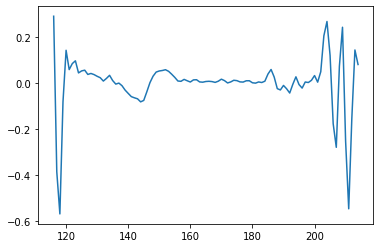

In [706]:
plt.plot(fxvals[116:215])
a = rpeaks.loc[:].values
rpeak = a.flatten()


In [712]:
np.median(rr_int)
np.median(np.diff(rpeak))

89.0

In [716]:
from scipy import signal

In [717]:
x = np.linspace(0,89, 89, endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 89)
xnew = np.linspace(0, 89, 89, endpoint=False)
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')


In [726]:
rpeak[101]-rpeak[100]
rpeak[102]-rpeak[101]


100.0

In [734]:
x = np.linspace(0,89, int(rpeak[101]-rpeak[100]+1), endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 89)
xnew = np.linspace(0, 89, 89, endpoint=False)
plt.figure(figsize=(10,8)) 
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0])#, 'ro')
#plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')

plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [755]:
%matplotlib qt
x = np.linspace(0,89, int(rpeak[102]+1-rpeak[101]), endpoint=False)
y = np.cos(-x**2/6.0)
f1 = signal.resample(y, 89)
xnew = np.linspace(0, 89, 89, endpoint=False)
# plt.figure(figsize=(10,8)) 
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0])#, 'ro')
#plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')

# plt.legend(['data', 'resampled'], loc='best')
# plt.show()

In [756]:
x = np.linspace(0,89, int(rpeak[101]-rpeak[100]+1), endpoint=False)
y = np.cos(-x**2/6.0)
f2 = signal.resample(y, 89)
xnew = np.linspace(0, 89, 89, endpoint=False)
# plt.figure(figsize=(10,8)) 
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0])#, 'ro')
# #plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')

# plt.legend(['data', 'resampled'], loc='best')
# plt.show()

In [745]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

tmp_yf = sklearn.metrics.pairwise.cosine_similarity(y, f, dense_output=True)

In [757]:
cos_sim = dot(f1, f2)/(norm(f1)*norm(f2))

In [759]:
cos_sim
plt.plot(f1)
plt.plot(f2)

In [312]:
# rpeaks, fxvals

In [313]:
dtype = rpeakList[0].split('_')[-2]
PtId = rpeakList[0].split('_')[-1].split('.csv')[0]

In [314]:
# rpeak = rpeaks.loc[0].values
# minmax normalization for fxvals(ECG Voltage)
fxvals_MinMax = min_max_scaler.fit_transform(fxvals)

In [315]:
tmp_rpeaks = rpeaks.loc[2].values
tmp_rpeaks

array([662.])

In [316]:
len(rr_intervals)

5156

In [456]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]

In [459]:
rpeaks = pd.read_csv(rpeakList[0], header=None)

array([[1.16000e+02],
       [2.09000e+02],
       [2.98000e+02],
       ...,
       [4.60509e+05],
       [4.60596e+05],
       [4.60681e+05]])

In [328]:
tmp_path = r'C:\Users\MI2RL-KHJ'
os.listdir(tmp_path) # 
ts = '20210805_ts.csv' 
beats = '20210805_beats.csv'

In [329]:
ts = pd.read_csv(os.path.join(tmp_path, ts), header = None)
ts

,0
0,209
1,298
2,392
3,498
4,588
...,...
5151,460333
5152,460421
5153,460509
5154,460596


In [330]:
beats = pd.read_csv(os.path.join(tmp_path, beats), header = None)
beats

,0
0,116
1,209
2,298
3,392
4,498
...,...
5152,460333
5153,460421
5154,460509
5155,460596


In [339]:
np.logical_and(hr >= 40, hr <= 200)

array([], shape=(5157, 0), dtype=bool)

In [352]:
# filtering 
# {'ftype': 'FIR', 'order': 38, 'frequency': [3, 45], 'band': 'bandpass'}

In [375]:
import csv
os.listdir(tmp_path) # 
ts = '20210805_ts.csv' 
beats = '20210805_beats.csv'

# load ts data 
ts_dat = open(os.path.join(tmp_path, ts))
reader = csv.reader(ts_dat)
ts_list = list(reader)

# flatten lists to one list 
ts_list = sum(ts_list, [])
# str to int in list
ts_list = list(map(int, ts_list))

# load beat data 
beats_dat = open(os.path.join(tmp_path, beats))
reader = csv.reader(beats_dat)
beats_list = list(reader)

# flatten lists to one list 
beats_list = sum(beats_list, [])
# str to int in list
beats_list = list(map(int, beats_list))

In [382]:
# heart rates
hr = 128*(60 /np.diff(beats_list))
len(hr), hr

(5156,
 array([82.58064516, 86.29213483, 81.70212766, ..., 87.27272727,
        88.27586207, 90.35294118]))

In [405]:
# check zerovalue and physiological limits for possible heart rates
indx = np.nonzero(np.logical_and(hr >= 40, hr <= 200))
indx

# 
hr[indx], np.array(ts_list)[indx]

# suze 
# options = {'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': False}

# smooth with moving average
if smooth and (len(hr) > 1):
    hr, _ = smoother(signal=hr, kernel='boxcar', size=size, mirror=True)

return utils.ReturnTuple((ts, hr), ('index', 'heart_rate'))

(array([82.58064516, 86.29213483, 81.70212766, ..., 87.27272727,
        88.27586207, 90.35294118]),
 array([   209,    298,    392, ..., 460509, 460596, 460681]))

In [415]:
# load ts data 
indx_dat = open(os.path.join(tmp_path,'20210805_indx.csv'))
reader = csv.reader(indx_dat)
indx_list = list(reader)


In [419]:
# flatten lists to one list 
indx_list = sum(indx_list, [])
# str to int in list
indx_list = list(map(int, indx_list))


In [422]:
len(hr[indx_list])

5118

In [461]:
## available rpeak
len(rpeaks.loc[:].values[indx_list])

5118

In [462]:
av_rpeaks = rpeaks.loc[:].values[indx_list]

In [475]:
int_av_rpeaks =  list(map(int, list(map(float, av_rpeaks))))
int_av_rpeaks

[116,
 209,
 298,
 392,
 498,
 588,
 683,
 781,
 877,
 970,
 1066,
 1163,
 1266,
 1363,
 1455,
 1549,
 1647,
 1736,
 1821,
 1919,
 2001,
 2100,
 2189,
 2284,
 2366,
 2460,
 2548,
 2633,
 2722,
 2819,
 2909,
 2996,
 3099,
 3191,
 3285,
 3380,
 3470,
 3568,
 3657,
 3751,
 3838,
 3924,
 4013,
 4104,
 4193,
 4286,
 4387,
 4490,
 4592,
 4686,
 4766,
 4851,
 4943,
 5024,
 5100,
 5180,
 5265,
 5350,
 5445,
 5544,
 5643,
 5741,
 5845,
 5931,
 6012,
 6092,
 6174,
 6260,
 6356,
 6461,
 6568,
 6662,
 6761,
 6864,
 6964,
 7052,
 7154,
 7247,
 7335,
 7431,
 7515,
 7606,
 7700,
 7796,
 7904,
 7997,
 8094,
 8171,
 8258,
 8347,
 8438,
 8536,
 8648,
 8739,
 8829,
 8918,
 9007,
 9100,
 9193,
 9285,
 9382,
 9445,
 9545,
 9625,
 9703,
 9782,
 9861,
 9941,
 10096,
 10179,
 10256,
 10335,
 10421,
 10490,
 10572,
 10648,
 10724,
 10802,
 10869,
 10955,
 11032,
 11105,
 11181,
 11258,
 11334,
 11412,
 11490,
 11568,
 11645,
 11721,
 11805,
 11872,
 11949,
 12031,
 12129,
 12235,
 12338,
 12433,
 12526,
 12620

In [476]:
av_hr = hr[indx_list]
av_hr

array([82.58064516, 86.29213483, 81.70212766, ..., 87.27272727,
       88.27586207, 90.35294118])

In [472]:
av_indx = hr[indx_list]

In [478]:
rr_intervals = [] 
for p in range(len(int_av_rpeaks)):
    if p < len(int_av_rpeaks)-1:
        rr_range = list(range(int(int_av_rpeaks[p]), int(int_av_rpeaks[p+1])))    
        rr_interval = fxvals_MinMax[rr_range]
        rr_intervals.append(rr_interval)

In [482]:
len(rr_intervals[0]), len(rr_intervals[1]), len(rr_intervals[2])

(93, 89, 94)

In [487]:

len(rr_intervals[0])/hr[0], len(rr_intervals[1])/hr[1], len(rr_intervals[2])/hr[2]

(1.126171875, 1.0313802083333334, 1.1505208333333332)

In [495]:
len(rr_intervals[0]), hr[0], 1/len(rr_intervals[0]), 1/hr[0]

(93, 82.58064516129032, 0.010752688172043012, 0.012109375)

In [499]:
a = len(rr_intervals[0])/hr[0]

In [505]:
b = hr[0]/len(rr_intervals[0])

In [507]:
b*len(rr_intervals[0])

82.58064516129032

In [508]:
b1 = hr[1]/len(rr_intervals[1])

In [509]:
b1*len(rr_intervals[1])

86.29213483146067

In [534]:
import harold

G = harold.Transfer(1, [1,2,1,2,1])

H_zoh = harold.discretize(G, dt=0.1, method='zoh')

H_zoh.polynomials

(array([[4.00405054e-06, 4.23311231e-05, 4.06726141e-05, 3.55134460e-06]]),
 array([[ 1.        , -3.80872323,  5.43808046, -3.44799742,  0.81873075]]))

In [535]:
# sum(int(H_zoh.polynomials[0][0]).tolist(),[])
list(map(int,H_zoh.polynomials[0][0].tolist())), H_zoh.polynomials[0][0].tolist()


([0, 0, 0, 0],
 [4.004050535697766e-06,
  4.23311230778591e-05,
  4.067261413880061e-05,
  3.5513445967585106e-06])

In [ ]:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lti.html#scipy.signal.lti

In [541]:
# def test_gbt(self):
#         ac = np.eye(2)
#         bc = 0.5 * np.ones((2, 1))
#         cc = np.array([[0.75, 1.0], [1.0, 1.0], [1.0, 0.25]])
#         dc = np.array([[0.0], [0.0], [-0.33]])

#         dt_requested = 0.5
#         alpha = 1.0 / 3.0

#         ad_truth = 1.6 * np.eye(2)
#         bd_truth = 0.3 * np.ones((2, 1))
#         cd_truth = np.array([[0.9, 1.2],
#                              [1.2, 1.2],
#                              [1.2, 0.3]])
#         dd_truth = np.array([[0.175],
#                              [0.2],
#                              [-0.205]])

#         ad, bd, cd, dd, dt = d2c((ac, bc, cc, dc), dt_requested,
#                                  method='gbt', alpha=alpha)

#         assert_array_almost_equal(ad_truth, ad)
#         assert_array_almost_equal(bd_truth, bd)
#         assert_array_almost_equal(cd_truth, cd)
#         assert_array_almost_equal(dd_truth, dd)

In [540]:
import d2c 



In [550]:
np.median(av_hr)

86.29213483146067

(array([  59.,  147., 1864., 2216.,  693.,  103.,   13.,   11.,    4.,
           8.]),
 array([ 40.20942408,  54.92018899,  69.6309539 ,  84.34171881,
         99.05248372, 113.76324863, 128.47401354, 143.18477844,
        157.89554335, 172.60630826, 187.31707317]),
 <BarContainer object of 10 artists>)

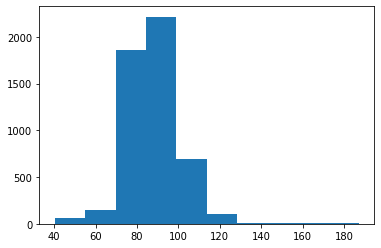

In [561]:
%matplotlib inline
#plt.figure(figsize=(12,10))
#plt.plot(av_hr)
plt.hist(av_hr)


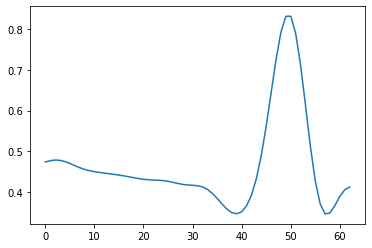

In [687]:
plt.plot(rr_intervals[100])


In [567]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
hrList = [i for i in os.listdir(PATH_IN) if i.startswith('raw_hr')]
indxList = [i for i in os.listdir(PATH_IN) if i.startswith('indx')]

In [597]:
# sample norm 00 
hr = hrList[0]
indx = indxList[0]

tmp_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
# load ts data 
hr_dat = open(os.path.join(tmp_path, hr))
reader = csv.reader(hr_dat)
hr_list = list(reader)

# flatten lists to one list 
hr_list = sum(hr_list, [])
# str to int in list
hr_list = list(map(float, hr_list))

# load ts data 
indx_dat = open(os.path.join(tmp_path, indx))
reader = csv.reader(indx_dat)
indx_list = list(reader)

# flatten lists to one list 
indx_list = sum(indx_list, [])
# str to int in list
indx_list = list(map(float, indx_list))

In [599]:
len(hr_list), len(indx_list)

(5118, 5118)

(array([  13.,  153., 1246., 1913., 1158.,  465.,  127.,   28.,   11.,
           4.]),
 array([ 51.0439048 ,  60.93727158,  70.83063837,  80.72400515,
         90.61737193, 100.51073871, 110.4041055 , 120.29747228,
        130.19083906, 140.08420585, 149.97757263]),
 <BarContainer object of 10 artists>)

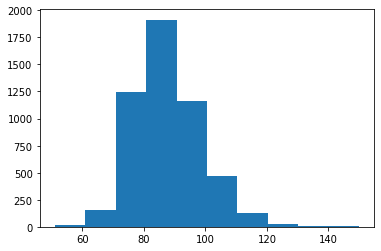

In [601]:
plt.hist(hr_list)

In [606]:
tmp_hr = np.array(hr_list)

In [627]:
# min_max (heart rate)
# min-max normalization 
min_max_scaler = MinMaxScaler()
# minmax normalization (Heart Voltage)
hr_MinMax = min_max_scaler.fit_transform(pd.DataFrame(tmp_hr))

In [638]:
df_tmp_hr = pd.DataFrame(tmp_hr)
df_tmp_hr.info(), df_tmp_hr.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5118 entries, 0 to 5117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5118 non-null   float64
dtypes: float64(1)
memory usage: 40.1 KB


(None,
                  0
 count  5118.000000
 mean     87.791603
 std      10.937008
 min      51.043905
 25%      80.074250
 50%      86.618999
 75%      94.197574
 max     149.977573)

In [654]:
df_tmp_hr[0].value_counts(normalize=True)
#(normalize=True)

87.607106    0.002735
96.010002    0.002540
83.179056    0.002345
84.117014    0.002345
88.283638    0.002345
               ...   
85.842143    0.000195
98.969268    0.000195
92.290152    0.000195
80.606256    0.000195
85.987765    0.000195
Name: 0, Length: 2991, dtype: float64

In [660]:
indx_list = list(map(int,indx_list))

In [674]:
tmp_rpeak = list(rpeaks[0].values)

len(tmp_rpeak)

indx

'indx_ecg_norm_00.csv'

In [679]:
pd.DataFrame(indx_list)

,0
0,209
1,298
2,392
3,498
4,588
...,...
5113,460333
5114,460421
5115,460509
5116,460596


In [680]:
pd.DataFrame(tmp_rpeak)

,0
0,116.0
1,209.0
2,298.0
3,392.0
4,498.0
...,...
5152,460333.0
5153,460421.0
5154,460509.0
5155,460596.0


## ----

In [320]:
np.mean(rr_intervals[0])

0.5038841038922443

In [423]:
rpeaks = pd.read_csv(rpeakList[0], header=None)

In [429]:
# load ts data 

rpeak_dat = open(rpeakList[0])
reader = csv.reader(rpeak_dat)
rpeak_list = list(reader)

# flatten lists to one list 
rpeak_list = sum(rpeak_list, [])
# str to int in list
#rpeak_list = list(map(int, rpeak_list))

In [437]:
rpeak_list = list(map(int, list(map(float, rpeak_list))))

In [442]:
len(indx_list)

5118

In [453]:
len(np.array(rpeak_list)), len(np.array(indx_list))

(2272, 5118)

In [449]:
np.array(rpeak_list)[np.array(indx_list)]

IndexError: index 2272 is out of bounds for axis 0 with size 2272

In [273]:
len(fxvals_MinMax[rr_range])

93

In [306]:
def ecl_rr_interval_distribution(rpeakList, fxvalList, plot_yesno, plot_range, ecl_dist_yesno, ecl_dist_plot_yesno):
    
    # ba_set_time: set before, after time based on rpeak
    # plot_yesno: if you want to make a plot, write "yes" or not "no"
    # ecl_dist_yesno: if you want to calculate euclidean distance, write "yes" or not  "no"
    # ecl_dist_yesno: if you want to plot the distribution of euclidean distance, write "yes" or not "no"
    
    set_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_inteval\norm_cutoff_plot'

    # min-max normalization 
    min_max_scaler = MinMaxScaler()
    plt.ioff()
   
    for i in range(len(rpeakList)):
            
        # Designate PtId, data type, fxvalId
        PtId = rpeakList[i].split('.csv')[0].split('_')[-1] 
        print('Processing >>>>> ', PtId)
        dtype = rpeakList[i].split('.csv')[0].split('_')[-2]
        fxvalId = rpeakList[i].split('.csv')[0].split('_')[-1]
        indxId = indexList[i].split('.csv')[0].split('_')[-1]
        hrId = hrList[i].split('.csv')[0].split('_')[-1]
               
#         # make directgory
#         if not os.path.exists(os.path.join(set_path, dtype, 'ba'+str(ba_set_time))):
#             os.mkdir(os.path.join(set_path, dtype, 'ba'+str(ba_set_time)))
#         else:
#             pass

        # load index
        # index data = valid data based on physiologcial limits(heart rate limits: not zero, 30 < hr < 200)
        if PtId == indxId:
            # load index
            indx_dat = open(indxList[i])
            reader = csv.reader(indx_dat)
            indx_list = list(reader)
            # flatten lists to one list 
            indx_list = sum(indx_list, [])
            # str to int in list
            indx_list = list(map(int, indx_list))
            
        
        # Check id, if they are same, load each file
        if PtId == fxvalId:
            # Load correct rpeaks data
            rpeaks = pd.read_csv(rpeakList[i], header=None)    
    
            # Load filtered x-value data
            fxvals = pd.read_csv(fxvalList[i], header=None)
            # minmax normalization for fxvals(ECG Voltage)
            fxvals_MinMax = min_max_scaler.fit_transform(fxvals)

         
        

        rr_intervals = [] 
        for p in range(len(rpeaks)):
            if p < len(rpeaks)-1:
                rr_range = list(range(int(rpeaks.loc[p].values), int(rpeaks.loc[p+1].values)))    
                rr_interval = fxvals_MinMax[rr_range]
                rr_intervals.append(rr_interval)
        
                
        # plotting  _ex) 100 r-peaks with before/after 'ba_set_time(10, 15, 20, 95 point)' sample points       
        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))   

            # set range of rr-interval samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> RR-interval: {}'.format(PtId, dtype, tr), fontsize=10)
                ax.plot(rr_intervals[tr])
                #ax.scatter(len(rr_intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples RR-interval: <{}-{}>'.format(PtId, dtype), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\{}\rr_interval_{}_{}.png'.format(dtype, PtId, dtype))
            plt.close()                
        
        else:
            pass
        
        
        dist_base = np.median(rr_intervals)      
        # Get euclidean distance             
        if ecl_dist_yesno == 'yes':
            dists =[]
 #            print('length of rr_intervals:', len(rr_intervals), 'length of rs:', len(rs))
            
            for interval in range(len(intervals)):
                if len(rr_intervals[interval]) > 0:
#                     print(len(rr_intervals[interval]), 'dist_base: ', dist_base)
                    dist = distance.euclidean(rr_intervals[interval], dist_base)
#                     print('dist:', dist)
                    dists.append(dist)
                else:
                    pass
#             print('<{}-{}: R-peak -+{}> Cosine Similarity summary: mean {}, std: {}'.format(PtId, dtype, ba_set_time, np.mean(cos_sims), np.std(cos_sims)))
            with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\rr_interval_cos_sim_{}_summary.csv'.format(dtype), 'a') as f:
                f.write('{}, {}, {}, {}, \n'.format(PtId, dtype, np.mean(cos_sims), np.std(cos_sims)))
            
            
            
            if ecl_dist_plot_yesno == 'yes':

                # Plot Euclidean distance distribution
                plt.figure(figsize=(12,10))
                density, bins, _ = plt.hist(dists, density=True, alpha=0.3)
                count, _ = np.histogram(dists, bins)
                plt.title('<{}-{}> Euclidean distance distribution: R-peak -+{}'.format(PtId, dtype, ba_set_time), fontsize=14)
                plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
                xmin, xmax, ymin, ymax = plt.axis()

                tick = ((bins[-1] - bins[0])/len(bins))/2
                for x, y, num in zip(bins, density, count):
                    if num != 0:
                        plt.text(x+tick, y, num, horizontalalignment='center', verticalalignment='bottom')   

                total = np.sum(count)
                loose = total*0.9     # adjust %
                strict = total*0.8
                dists = sorted(dists)

                loose_text = 'Euclidean distance: {} for 90% R-peak -+{} > number: {},    [total_rpeaks: {}]'.format(np.round(dists[int(loose)], 3), ba_set_time, int(loose), total)
                strict_text = 'Euclidean distance: {} for 80% R-peak -+{} > number: {}'.format(np.round(dists[int(strict)], 3), ba_set_time, int(strict))

                plt.axvline(x=dists[int(loose)], color='b', linestyle='--', label='Loose', ymax=0.9)
                plt.axvline(x=dists[int(strict)], color='r', linestyle='--', label='Strict', ymax=0.9)
                plt.legend(loc='upper left', fontsize=13)
                plt.xlabel('Euclidean distance')
                plt.ylabel('The Density of R-peaks')
                plt.text(dists[int(loose)], ymax*0.9, int(loose), fontsize=9, color='b')
                plt.text(dists[int(strict)], ymax*0.95, int(strict), fontsize=9,  color='r')
                plt.text(xmin, ymin-np.max(density)*0.1, loose_text, fontsize=14)
                plt.text(xmin, ymin-np.max(density)*0.15, strict_text, fontsize=14)
                plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_inteval\norm_cutoff_plot\{}\ba{}\R-peak_ecl_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))             
                plt.close()
            else:
                pass
            
        else:
            pass

    with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_inteval\norm_cutoff_plot\ecl_{}_{}_summary.csv'.format(dtype, ba_set_time), 'a') as f:
        f.write('PtId, dtype, before/after, mean, std, \n')
    
#     break
    print('{}-before/after{} => Finished'.format(dtype, ba_set_time))                                                                                        


In [ ]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arrx'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
ecl_rr_interval_distribution(rpeakList, fxvalList, 95, 'yes', 100, 'yes', 'yes')
ecl_rr_interval_distribution(rpeakList, fxvalList, 15, 'yes', 100, 'yes', 'yes')
ecl_rr_interval_distribution(rpeakList, fxvalList, 10, 'yes', 100, 'yes', 'yes')
ecl_rr_interval_distribution(rpeakList, fxvalList, 20, 'yes', 100, 'yes', 'yes')

In [276]:

dtype = rpeakList[0].split('_')[-2]
PtId = rpeakList[0].split('_')[-1].split('.csv')[0]
plot_range = 10

rr_intervals = [] 
for peak in range(len(rpeaks)):
    
    if peak < len(rpeaks)-1:
        rr_range = list(range(int(rpeaks.loc[peak].values), int(rpeaks.loc[peak+1].values)))    
        rr_interval = fxvals_MinMax[rr_range]
        rr_intervals.append(rr_interval)
        
    # plotting  _ex) 100 r-peaks with before/after 'ba_set_time(10, 15, 20, 95 point)' sample points
#     if plot_yesno == 'yes' :

fig = plt.figure(figsize=(30,25))#, constrained_layout=True, sharex=True, sharey=True)       

# set range of rpeak samples
target_range = range(plot_range, plot_range+100)                    
n = 1 
#ax = plt.subplots(10,10)#, sharex=True, sharey=True)
for tr in target_range:
    ax = plt.subplot(10,10, n)
    plt.subplots_adjust(hspace = 0.4)
    plt.title('<{}-{}> RR-interval: {}'.format(PtId, dtype, tr), fontsize=10)
    ax.plot(rr_intervals[tr])
    #ax.scatter(len(rr_intervals[tr])/2,rs[tr], c='r')
    n+=1 
fig.suptitle('100 Examples RR-interval: <{}-{}>'.format(PtId, dtype), fontsize=20, y=0.92)
fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\{}\R-peak_{}_{}.png'.format(dtype, PtId, dtype))
plt.close()

    
    

In [ ]:
        # plotting  _ex) 100 r-peaks with before/after 'ba_set_time(10, 15, 20, 95 point)' sample points
        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))#, constrained_layout=True, sharex=True, sharey=True)       
            
            # set range of rpeak samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> R-peak -+{}: {}'.format(PtId, dtype, ba_set_time, tr), fontsize=10)
                ax.plot(intervals[tr])
                ax.scatter(len(intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples R-peak: <{}-{}> -+{}'.format(PtId, dtype, ba_set_time), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\norm_cutoff_plot\{}\ba{}\R-peak_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype, ba_set_time))
            plt.close()
        

## RR-interval Euclidean distance

In [308]:
def ecl_rr_interval_distribution(rpeakList, fxvalList, plot_yesno, plot_range, ecl_sim_yesno, ecl_plot_yesno):
    
    # ba_set_time: set before, after time based on rpeak
    # plot_yesno: if you want to make a plot, write "yes" or not "no"
    # ecl_dist_yesno: if you want to calculate euclidean distance, write "yes" or not  "no"
    # ecl_dist_yesno: if you want to plot the distribution of euclidean distance, write "yes" or not "no"
    
    set_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot'

    # min-max normalization 
    min_max_scaler = MinMaxScaler()
    plt.ioff()
   
    for i in range(len(rpeakList)):
            
        # Designate PtId, data type, fxvalId
        PtId = rpeakList[i].split('.csv')[0].split('_')[-1] 
        print('Processing >>>>> ', PtId)
        dtype = rpeakList[i].split('.csv')[0].split('_')[-2]

        fxvalId = rpeakList[i].split('.csv')[0].split('_')[-1]
        
        # Check id, if they are same, load each file
        if PtId == fxvalId:
            # Load correct rpeaks data
            rpeaks = pd.read_csv(rpeakList[i], header=None)    
            # Load filtered x-value data
            fxvals = pd.read_csv(fxvalList[i], header=None)
            # minmax normalization for fxvals(ECG Voltage)
            fxvals_MinMax = min_max_scaler.fit_transform(fxvals)
        
                
        rr_intervals = [] 
        for p in range(len(rpeaks)):
            if p < len(rpeaks)-1:
                rr_range = list(range(int(rpeaks.loc[p].values), int(rpeaks.loc[p+1].values)))    
                rr_interval = fxvals_MinMax[rr_range]
                rr_intervals.append(rr_interval)
        
        

        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))   

            # set range of rr-interval samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> RR-interval: {}'.format(PtId, dtype, tr), fontsize=10)
                ax.plot(rr_intervals[tr])
                #ax.scatter(len(rr_intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples RR-interval: <{}-{}>'.format(PtId, dtype), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\{}\rr_interval_{}_{}.png'.format(dtype, PtId, dtype))
            plt.close()                
        
        else:
            pass
            
            
        dist_base = np.median(rr_intervals)      
        # Get euclidean distance             
        if ecl_dist_yesno == 'yes':   
            dists = []
            for rr in range(len(rr_intervals)):
                dist = distance.euclidean(rr_intervals[rr], dist_base)
                dists.append(dist)
            with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\rr_interval_ecl_{}_summary.csv'.format(dtype), 'a') as f:
                f.write('{}, {}, {}, {}, \n'.format(PtId, dtype, np.mean(dists), np.std(dists)))

            
            
            if ecl_dist_plot_yesno == 'yes':

                # Plot Euclidean distance distribution
                plt.figure(figsize=(12,10))
                density, bins, _ = plt.hist(dists, density=True, alpha=0.3)
                count, _ = np.histogram(dists, bins)
                plt.title('<{}-{}> Euclidean distance distribution: RR-interval'.format(PtId, dtype), fontsize=14)
                plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
                xmin, xmax, ymin, ymax = plt.axis()

                tick = ((bins[-1] - bins[0])/len(bins))/2
                for x, y, num in zip(bins, density, count):
                    if num != 0:
                        plt.text(x+tick, y, num, horizontalalignment='center', verticalalignment='bottom')   

                total = np.sum(count)
                loose = total*0.9     # adjust %
                strict = total*0.8
                dists = sorted(dists)

                loose_text = 'Euclidean distance: {} for 90% RR-interval > number: {},    [total_RR-interval: {}]'.format(np.round(dists[int(loose)], 3), int(loose), total)
                strict_text = 'Euclidean distance: {} for 80% RR-interval > number: {}'.format(np.round(dists[int(strict)], 3), int(strict))
                
                plt.axvline(x=dists[int(loose)], color='b', linestyle='--', label='Loose', ymax=0.9)
                plt.axvline(x=dists[int(strict)], color='r', linestyle='--', label='Strict', ymax=0.9)
                plt.legend(loc='upper left', fontsize=13)
                plt.xlabel('Euclidean distance')
                plt.ylabel('The Density of R-peaks')
                plt.text(dists[int(loose)], ymax*0.9, int(loose), fontsize=9, color='b')
                plt.text(dists[int(strict)], ymax*0.95, int(strict), fontsize=9,  color='r')
                plt.text(xmin, ymin-np.max(density)*0.1, loose_text, fontsize=14)
                plt.text(xmin, ymin-np.max(density)*0.15, strict_text, fontsize=14)
                plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_inteval\norm_cutoff_plot\{}\R-peak_ecl_{}_{}_ba{}.png'.format(dtype, ba_set_time, PtId, dtype))             
                plt.close()
            else:
                pass
            
        else:
            pass

    with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_inteval\norm_cutoff_plot\ecl_{}_summary.csv'.format(dtype), 'a') as f:
        f.write('PtId, dtype, mean, std, \n')
    
#     break
    print('{} => Finished'.format(dtype))                                                                                        


In [309]:
# ecl_rr_interval_distribution(rpeakList, fxvalList, plot_yesno, plot_range, ecl_sim_yesno, ecl_plot_yesno)
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
ecl_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')


Processing >>>>>  00


C:\Users\MI2RL-KHJ\anaconda3\envs\ecg_env\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (298,1) (293,1) 

In [310]:
rr_inetrvals



NameError: name 'rr_inetrvals' is not defined

## RR-interval Cosine similarity

In [ ]:
# sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)

In [302]:
def cos_sim_rr_interval_distribution(rpeakList, fxvalList, plot_yesno, plot_range, cos_sim_yesno, cos_sim_plot_yesno):
    
    # ba_set_time: set before, after time based on rpeak
    # plot_yesno: if you want to make a plot, write "yes" or not "no"
    # ecl_dist_yesno: if you want to calculate euclidean distance, write "yes" or not  "no"
    # ecl_dist_yesno: if you want to plot the distribution of euclidean distance, write "yes" or not "no"
    
    set_path = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot'

    # min-max normalization 
    min_max_scaler = MinMaxScaler()
    plt.ioff()
   
    for i in range(len(rpeakList)):
            
        # Designate PtId, data type, fxvalId
        PtId = rpeakList[i].split('.csv')[0].split('_')[-1] 
        print('Processing >>>>> ', PtId)
        dtype = rpeakList[i].split('.csv')[0].split('_')[-2]

        fxvalId = rpeakList[i].split('.csv')[0].split('_')[-1]
        
        # Check id, if they are same, load each file
        if PtId == fxvalId:
            # Load correct rpeaks data
            rpeaks = pd.read_csv(rpeakList[i], header=None)    
            # Load filtered x-value data
            fxvals = pd.read_csv(fxvalList[i], header=None)
            # minmax normalization for fxvals(ECG Voltage)
            fxvals_MinMax = min_max_scaler.fit_transform(fxvals)
        
                
        rr_intervals = [] 
        for p in range(len(rpeaks)):
            if p < len(rpeaks)-1:
                rr_range = list(range(int(rpeaks.loc[p].values), int(rpeaks.loc[p+1].values)))    
                rr_interval = fxvals_MinMax[rr_range]
                rr_intervals.append(rr_interval)
        
        

        if plot_yesno == 'yes' :
            fig = plt.figure(figsize=(30,25))   

            # set range of rr-interval samples
            target_range = range(plot_range, plot_range+100)                    
            n = 1 
            #ax = plt.subplots(10,10)#, sharex=True, sharey=True)
            for tr in target_range:
                ax = plt.subplot(10,10, n)
                plt.subplots_adjust(hspace = 0.4)
                plt.title('<{}-{}> RR-interval: {}'.format(PtId, dtype, tr), fontsize=10)
                ax.plot(rr_intervals[tr])
                #ax.scatter(len(rr_intervals[tr])/2,rs[tr], c='r')
                n+=1 
            fig.suptitle('100 Examples RR-interval: <{}-{}>'.format(PtId, dtype), fontsize=20, y=0.92)
            fig.supxlabel('Times (Sample points)',fontsize=15, horizontalalignment='center', y=0.1)
            fig.supylabel('Normalized Voltage',fontsize=15, verticalalignment='center', x=0.1)     
            plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\{}\rr_interval_{}_{}.png'.format(dtype, PtId, dtype))
            plt.close()                
        
        else:
            pass
                            
        
        
        # Get Cosine similarity  
        if cos_sim_yesno == 'yes':
            cos_sims =[]            
            for interval in range(len(rr_intervals)):
                if len(rr_intervals[interval]) > 0:
                    if interval < len(intervals)-1:
                        A = np.array(sum(rr_intervals[interval].tolist(), []))
                        B = np.array(sum(rr_intervals[interval+1].tolist(), []))
                        cos_sim = dot(A, B)/(norm(A)*norm(B))
                    else:
                        break
                    cos_sims.append(cos_sim)
                else:
                    pass
#             print('<{}-{}: R-peak -+{}> Cosine Similarity summary: mean {}, std: {}'.format(PtId, dtype, ba_set_time, np.mean(cos_sims), np.std(cos_sims)))
            with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\rr_interval_cos_sim_{}_summary.csv'.format(dtype), 'a') as f:
                f.write('{}, {}, {}, {}, \n'.format(PtId, dtype, np.mean(cos_sims), np.std(cos_sims)))
            
            
            if cos_sim_plot_yesno == 'yes':

                # Plot Cosine similarity distribution
                plt.figure(figsize=(12,10))
                density, bins, _ = plt.hist(cos_sims, density=True, alpha=0.3)
                count, _ = np.histogram(cos_sims, bins)
                plt.title('<{}-{}> Cosine similarity distribution: RR_interval'.format(PtId, dtype), fontsize=14)
                plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
                xmin, xmax, ymin, ymax = plt.axis()

                tick = ((bins[-1] - bins[0])/len(bins))/2
                for x, y, num in zip(bins, density, count):
                    if num != 0:
                        plt.text(x+tick, y, num, horizontalalignment='center', verticalalignment='bottom')   

                total = np.sum(count)
                loose = total*0.9     # adjust %
                strict = total*0.8
                cos_sims = sorted(cos_sims)

                loose_text = 'Cosine similarity: {} for 90% RR-interval > number: {},    [total_RR-interval: {}]'.format(np.round(cos_sims[int(loose)], 3), int(loose), total)
                strict_text = 'Cosine similarity: {} for 80% RR-interval > number: {}'.format(np.round(cos_sims[int(strict)], 3), int(strict))

                plt.axvline(x=cos_sims[int(loose)], color='b', linestyle='--', label='Loose', ymax=0.9)
                plt.axvline(x=cos_sims[int(strict)], color='r', linestyle='--', label='Strict', ymax=0.9)
                plt.legend(loc='upper left', fontsize=13)
                plt.xlabel('Cosine similarity')
                plt.ylabel('The Density of R-peaks')
                plt.text(cos_sims[int(loose)]*1.05, ymax*0.9, int(loose), fontsize=9, color='b')
                plt.text(cos_sims[int(strict)]*1.05, ymax*0.8, int(strict), fontsize=9,  color='r')
                plt.text(xmin, ymin-np.max(density)*0.1, loose_text, fontsize=14)
                plt.text(xmin, ymin-np.max(density)*0.15, strict_text, fontsize=14)
                plt.savefig(r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\rr_interval_cos_sim_{}_{}.png'.format(dtype, PtId, dtype))             
                plt.close()
            else:
                pass
            
        else:
            pass

    with open (r'C:\Users\MI2RL-KHJ\workspace_signal\mit\rr_interval\norm_cutoff_plot\rr_interval_cos_sim_{}_summary.csv'.format(dtype), 'a') as f:
        f.write('PtId, dtype, mean, std, \n')
    
#     break
    print('{} => Finished'.format(dtype))                                                                                        


In [286]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arr'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')

Processing >>>>>  00
Processing >>>>>  01
Processing >>>>>  02
Processing >>>>>  03
Processing >>>>>  04
Processing >>>>>  05
Processing >>>>>  06
Processing >>>>>  07
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  17
Processing >>>>>  18
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  23
Processing >>>>>  24
Processing >>>>>  25
Processing >>>>>  26
Processing >>>>>  27
Processing >>>>>  28
Processing >>>>>  29
Processing >>>>>  30
Processing >>>>>  31
Processing >>>>>  32
Processing >>>>>  33
Processing >>>>>  34
Processing >>>>>  35
Processing >>>>>  36
Processing >>>>>  37
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>

OSError: [Errno 22] Invalid argument: 'C:\\Users\\MI2RL-KHJ\\workspace_signal\\mit\\rr_interval\\norm_cutoff_plot\\arr\\rr_interval_12_arr.png'

In [288]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_arrx'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'yes', 100, 'yes', 'yes')

Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38
Processing >>>>>  39
Processing >>>>>  40
Processing >>>>>  41
Processing >>>>>  42
Processing >>>>>  43
Processing >>>>>  44
Processing >>>>>  45
Processing >>>>>  46
Processing >>>>>  47
arrx => Finished
Processing >>>>>  08
Processing >>>>>  09
Processing >>>>>  10
Processing >>>>>  11
Processing >>>>>  12
Processing >>>>>  13
Processing >>>>>  14
Processing >>>>>  15
Processing >>>>>  16
Processing >>>>>  19
Processing >>>>>  20
Processing >>>>>  21
Processing >>>>>  22
Processing >>>>>  38


OSError: [Errno 22] Invalid argument: 'C:\\Users\\MI2RL-KHJ\\workspace_signal\\mit\\rr_interval\\norm_cutoff_plot\\arrx\\rr_interval_38_arrx.png'

In [303]:
PATH_IN = r'C:\Users\MI2RL-KHJ\workspace_signal\mit\processed_norm'
os.chdir(PATH_IN)
rpeakList = [i for i in os.listdir(PATH_IN) if i.startswith('correct')]
fxvalList = [i for i in os.listdir(PATH_IN) if i.startswith('filtered')]
cos_sim_rr_interval_distribution(rpeakList, fxvalList, 'no', 100, 'yes', 'yes')

Processing >>>>>  00


ValueError: shapes (93,) and (89,) not aligned: 93 (dim 0) != 89 (dim 0)